# **Imports**

In [1]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2 as cv
from glob import glob
import tensorflow as tf

# Data 
from keras.preprocessing.image import img_to_array, array_to_img

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

In [2]:
path = '../input/cityscapes-image-pairs/cityscapes_data/train/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 160
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

  0%|          | 0/2975 [00:00<?, ?it/s]2022-08-26 14:48:03.970400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 14:48:04.116083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 14:48:04.116956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 14:48:04.120001: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

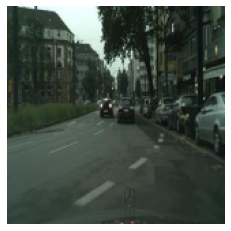

In [3]:
plt.imshow(images[45])
plt.axis('off')
plt.show()

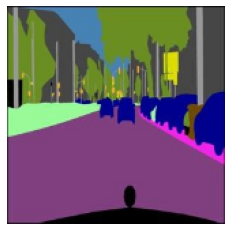

In [4]:
plt.imshow(masks[45])
plt.axis('off')
plt.show()

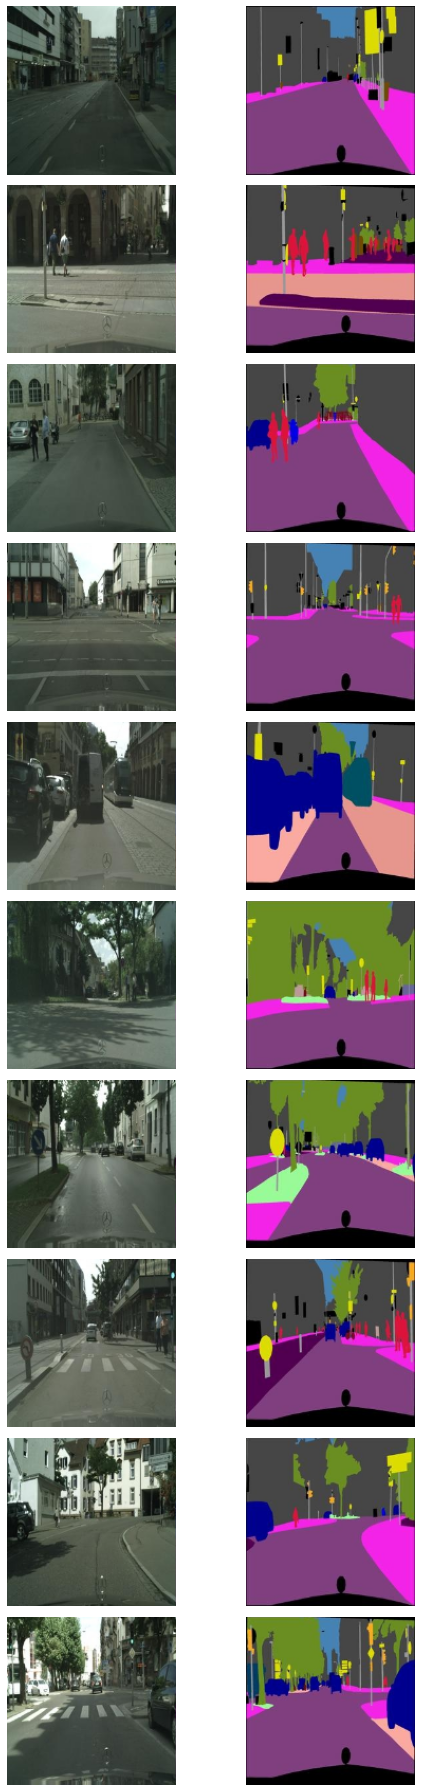

In [5]:
plt.figure(figsize=(8,25))
for i in range(1,21):
  plt.subplot(10,2,i)
  if i%2!=0:
    id = np.random.randint(len(images))
    image = images[id]
    plt.imshow(image)
    plt.axis('off')
  elif i%2==0:
    mask = masks[id]
    plt.imshow(mask)
    plt.axis('off')  
plt.tight_layout()
plt.show()

In [6]:
X_train, y_train = images[:2900], masks[:2900]
X_valid, y_valid = images[2900:], masks[2900:]

# **UNet Autoencoder**

In [7]:
# Encoder Layer Block
class EncoderLayerBlock(Layer):
  def __init__(self, filters, rate, pooling=True):
    super(EncoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.drop = Dropout(self.rate)
    self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.pool = MaxPool2D(pool_size=(2,2))

  def call(self, X):
    x = self.c1(X)
    x = self.drop(x)
    x = self.c2(x)
    if self.pooling:
      y = self.pool(x)
      return y, x
    else: 
      return x

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }

#  Decoder Layer
class DecoderLayerBlock(Layer):
  def __init__(self, filters, rate, padding='same'):
    super(DecoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
    self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.cT(X)
    c1 = concatenate([x, skip_X])
    y = self.next(c1)
    return y 

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
    }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(X_valid))
    rand_img = X_valid[id][np.newaxis,...]
    pred_mask = self.model.predict(rand_img)[0]
    true_mask = y_valid[id]

    
    plt.subplot(1,3,1)
    plt.imshow(rand_img[0])
    plt.title("Original Image")
    plt.axis('off')
    

    plt.subplot(1,3,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(true_mask)
    plt.title("True Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

2022-08-26 14:48:58.534284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-26 14:49:01.317855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


91/91 [==============================] - 19s 102ms/step - loss: 0.6328 - accuracy: 0.4390 - mean_io_u: 0.5000 - val_loss: 0.6134 - val_accuracy: 0.5742 - val_mean_io_u: 0.5000


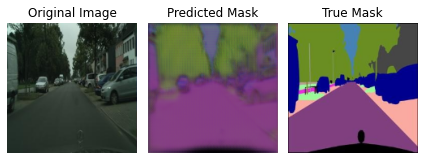

Epoch 2/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5948 - accuracy: 0.5309 - mean_io_u: 0.5000 - val_loss: 0.6006 - val_accuracy: 0.6715 - val_mean_io_u: 0.5000


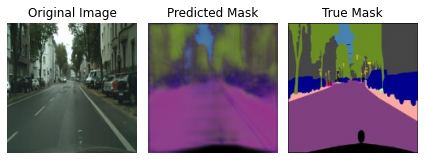

Epoch 3/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5854 - accuracy: 0.5931 - mean_io_u: 0.5000 - val_loss: 0.5902 - val_accuracy: 0.6633 - val_mean_io_u: 0.5000


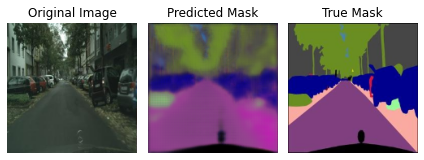

Epoch 4/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5787 - accuracy: 0.6163 - mean_io_u: 0.5000 - val_loss: 0.5866 - val_accuracy: 0.6881 - val_mean_io_u: 0.5000


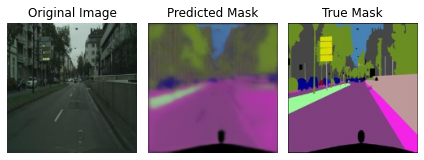

Epoch 5/50
91/91 [==============================] - 8s 82ms/step - loss: 0.5752 - accuracy: 0.6527 - mean_io_u: 0.5000 - val_loss: 0.5843 - val_accuracy: 0.7286 - val_mean_io_u: 0.5000


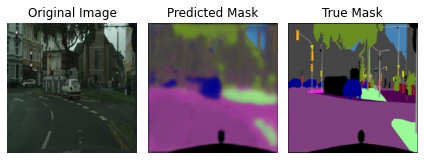

Epoch 6/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5726 - accuracy: 0.6761 - mean_io_u: 0.5000 - val_loss: 0.5841 - val_accuracy: 0.7400 - val_mean_io_u: 0.5000


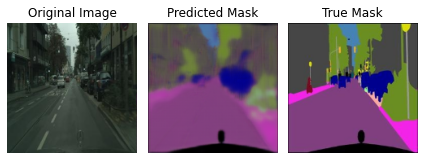

Epoch 7/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5693 - accuracy: 0.7017 - mean_io_u: 0.5000 - val_loss: 0.5805 - val_accuracy: 0.7315 - val_mean_io_u: 0.5000


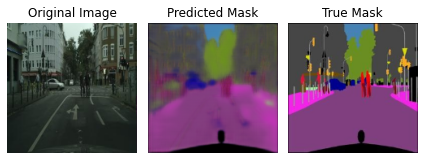

Epoch 8/50
91/91 [==============================] - 8s 85ms/step - loss: 0.5679 - accuracy: 0.6872 - mean_io_u: 0.5000 - val_loss: 0.5796 - val_accuracy: 0.7513 - val_mean_io_u: 0.5000


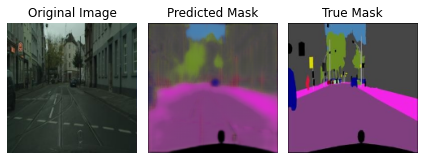

Epoch 9/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5656 - accuracy: 0.6875 - mean_io_u: 0.5000 - val_loss: 0.5799 - val_accuracy: 0.7401 - val_mean_io_u: 0.5000


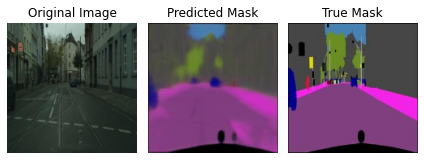

Epoch 10/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5647 - accuracy: 0.6923 - mean_io_u: 0.5000 - val_loss: 0.5779 - val_accuracy: 0.7386 - val_mean_io_u: 0.5000


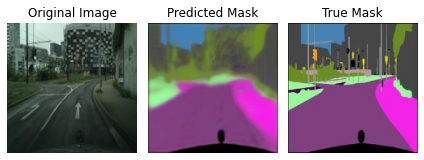

Epoch 11/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5631 - accuracy: 0.6898 - mean_io_u: 0.5000 - val_loss: 0.5779 - val_accuracy: 0.7596 - val_mean_io_u: 0.5000


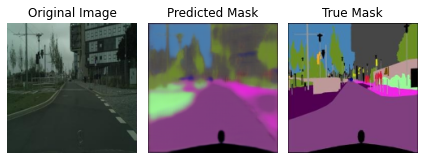

Epoch 12/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5626 - accuracy: 0.6903 - mean_io_u: 0.5000 - val_loss: 0.5767 - val_accuracy: 0.7359 - val_mean_io_u: 0.5000


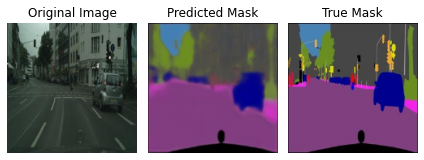

Epoch 13/50
91/91 [==============================] - 7s 82ms/step - loss: 0.5618 - accuracy: 0.6948 - mean_io_u: 0.5000 - val_loss: 0.5774 - val_accuracy: 0.7554 - val_mean_io_u: 0.5000


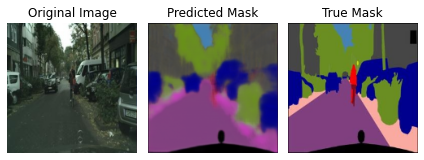

Epoch 14/50
91/91 [==============================] - 8s 85ms/step - loss: 0.5608 - accuracy: 0.6897 - mean_io_u: 0.5000 - val_loss: 0.5762 - val_accuracy: 0.7271 - val_mean_io_u: 0.5000


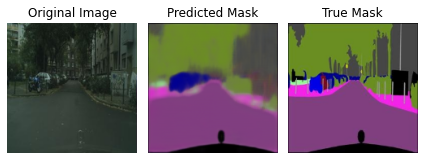

Epoch 15/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5603 - accuracy: 0.6916 - mean_io_u: 0.5000 - val_loss: 0.5758 - val_accuracy: 0.6486 - val_mean_io_u: 0.5000


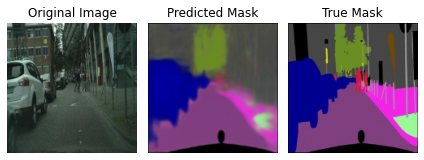

Epoch 16/50
91/91 [==============================] - 8s 85ms/step - loss: 0.5598 - accuracy: 0.6921 - mean_io_u: 0.5000 - val_loss: 0.5763 - val_accuracy: 0.7461 - val_mean_io_u: 0.5000


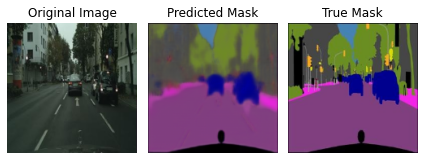

Epoch 17/50
91/91 [==============================] - 8s 85ms/step - loss: 0.5590 - accuracy: 0.6877 - mean_io_u: 0.5000 - val_loss: 0.5749 - val_accuracy: 0.7143 - val_mean_io_u: 0.5000


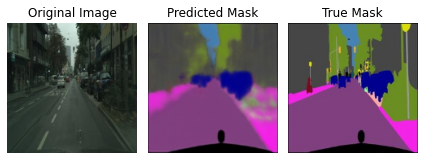

Epoch 18/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5584 - accuracy: 0.6968 - mean_io_u: 0.5000 - val_loss: 0.5749 - val_accuracy: 0.7352 - val_mean_io_u: 0.5000


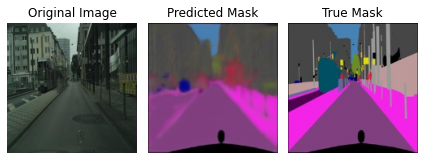

Epoch 19/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5581 - accuracy: 0.6967 - mean_io_u: 0.5000 - val_loss: 0.5741 - val_accuracy: 0.7540 - val_mean_io_u: 0.5000


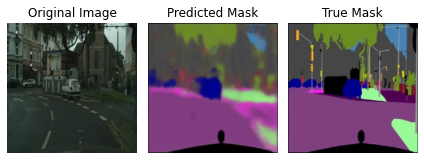

Epoch 20/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5575 - accuracy: 0.6994 - mean_io_u: 0.5000 - val_loss: 0.5743 - val_accuracy: 0.7377 - val_mean_io_u: 0.5000


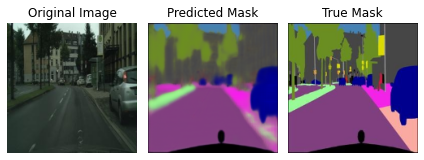

Epoch 21/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5572 - accuracy: 0.6963 - mean_io_u: 0.5000 - val_loss: 0.5750 - val_accuracy: 0.7050 - val_mean_io_u: 0.5000


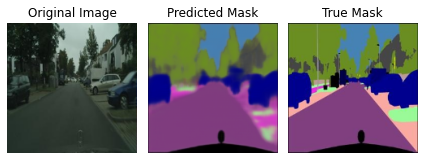

Epoch 22/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5566 - accuracy: 0.7037 - mean_io_u: 0.5000 - val_loss: 0.5741 - val_accuracy: 0.7207 - val_mean_io_u: 0.5000


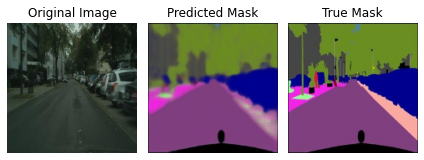

Epoch 23/50
91/91 [==============================] - 8s 84ms/step - loss: 0.5563 - accuracy: 0.6946 - mean_io_u: 0.5000 - val_loss: 0.5739 - val_accuracy: 0.7122 - val_mean_io_u: 0.5000


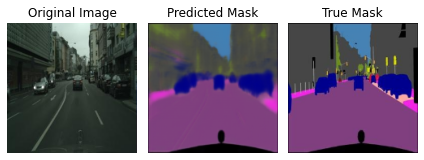

Epoch 24/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5557 - accuracy: 0.7016 - mean_io_u: 0.5000 - val_loss: 0.5730 - val_accuracy: 0.6595 - val_mean_io_u: 0.5000


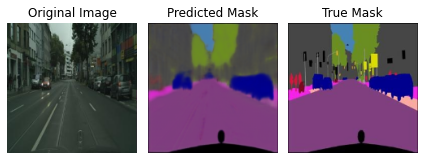

Epoch 25/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5558 - accuracy: 0.7061 - mean_io_u: 0.5000 - val_loss: 0.5742 - val_accuracy: 0.7590 - val_mean_io_u: 0.5000


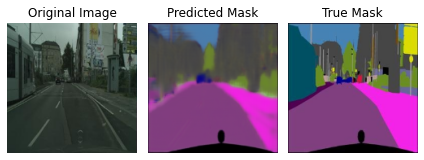

Epoch 26/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5553 - accuracy: 0.6984 - mean_io_u: 0.5000 - val_loss: 0.5731 - val_accuracy: 0.6978 - val_mean_io_u: 0.5000


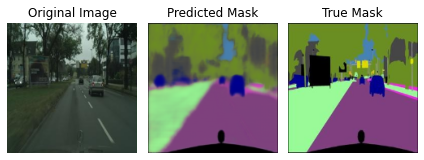

Epoch 27/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5549 - accuracy: 0.7059 - mean_io_u: 0.5000 - val_loss: 0.5732 - val_accuracy: 0.7102 - val_mean_io_u: 0.5000


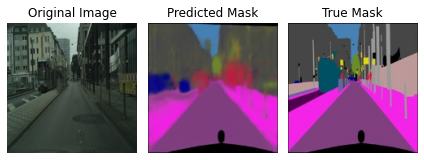

Epoch 28/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5543 - accuracy: 0.7096 - mean_io_u: 0.5000 - val_loss: 0.5749 - val_accuracy: 0.6954 - val_mean_io_u: 0.5000


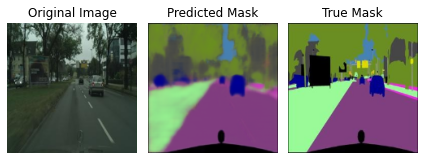

Epoch 29/50
91/91 [==============================] - 8s 83ms/step - loss: 0.5539 - accuracy: 0.7073 - mean_io_u: 0.5000 - val_loss: 0.5737 - val_accuracy: 0.6960 - val_mean_io_u: 0.5000


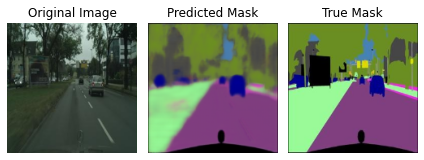

In [8]:
with tf.device('/GPU:0'):
    # Input Layer 
    input_layer = Input(shape=X_train.shape[-3:])

    # Encoder
    p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32,0.1)(p1)
    p3, c3 = EncoderLayerBlock(64,0.2)(p2)
    p4, c4 = EncoderLayerBlock(128,0.2)(p3)

    # Encoding Layer
    c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

    # Decoder
    d1 = DecoderLayerBlock(128,0.2)([c5, c4])
    d2 = DecoderLayerBlock(64,0.2)([d1, c3])
    d3 = DecoderLayerBlock(32,0.2)([d2, c2])
    d4 = DecoderLayerBlock(16,0.2)([d3, c1])

    # Output layer
    output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

    # U-Net Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compiling
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # Callbacks 
    callbacks =[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
        ShowProgress()
    ]

    # Train The Model
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=50,
        callbacks=callbacks
    )

This model architecture is famously known for its segmentation abilities and In this image data set it does its job. The model seems to lose some of the spatial information. This is because of the smaller size of the input images. I found something wrong with these true mask images. Which I used for validation purpose. 

# **Evaluation**

In [9]:
path = '../input/cityscapes-image-pairs/cityscapes_data/val/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 160
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

100%|██████████| 500/500 [00:07<00:00, 70.57it/s]


In [10]:
def show_image(image,title=None):
    plt.imshow(image)
    if title is not None: plt.title(title)
    plt.axis('off')

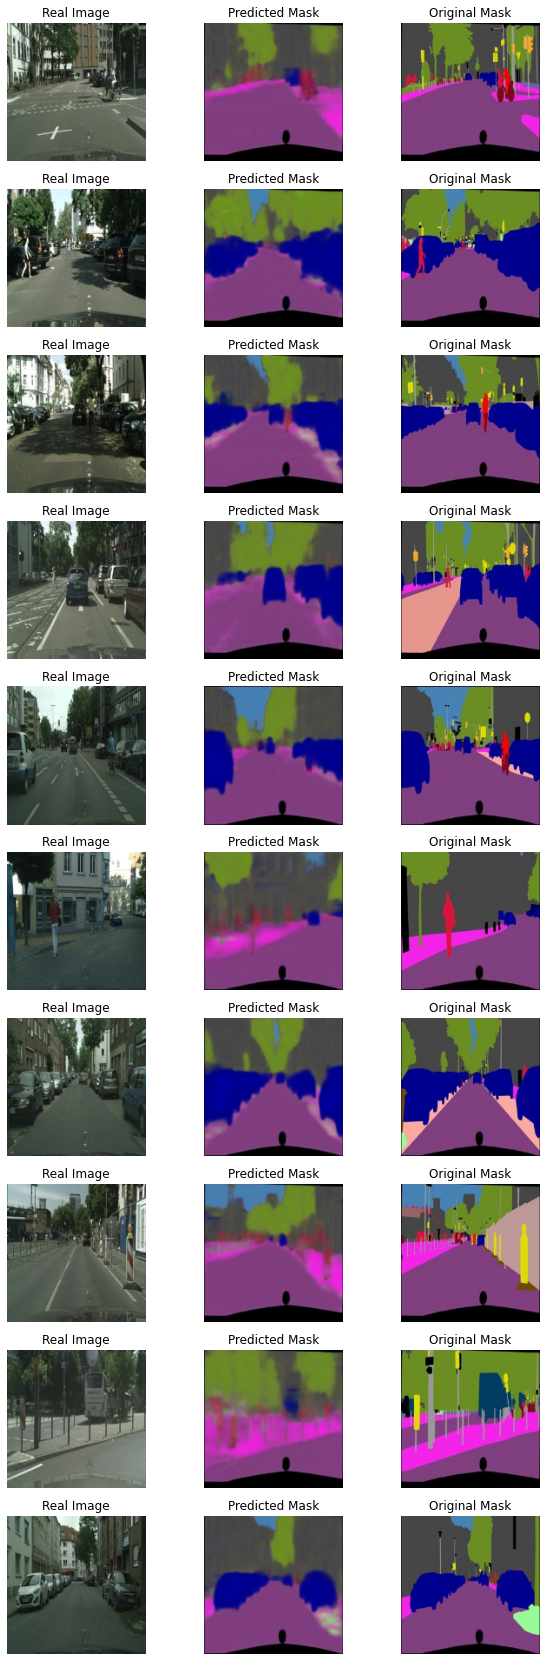

In [11]:
plt.figure(figsize=(10,30))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = model.predict(real_img)[0]
        mask = masks[id]
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask")
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask")
        n=0
plt.show()

If you ignore the blurriness, you can notice that for almost every image it predicted the right segmentation. And also classified the images correctly based on their pixel levels. You can also see that some of the informations are lost, such as the light pole, etc. Overall the model performed great and if you want even better results used a bigger image input size.

---
Thanks!!!